In [ ]:
## Notebook env: mirtud_env (R kernel)

In [1]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggpubr)

.libPaths('/home/ssobti/projects/mir_tud/mirtud_conda_extras')
library(ggbreak)

Loading required package: SeuratObject

Loading required package: sp




Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
ggbreak v0.1.2

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774846




In [2]:
adata.miR = readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_normalized_integrated_seurat.rds')
meta = adata.miR@meta.data

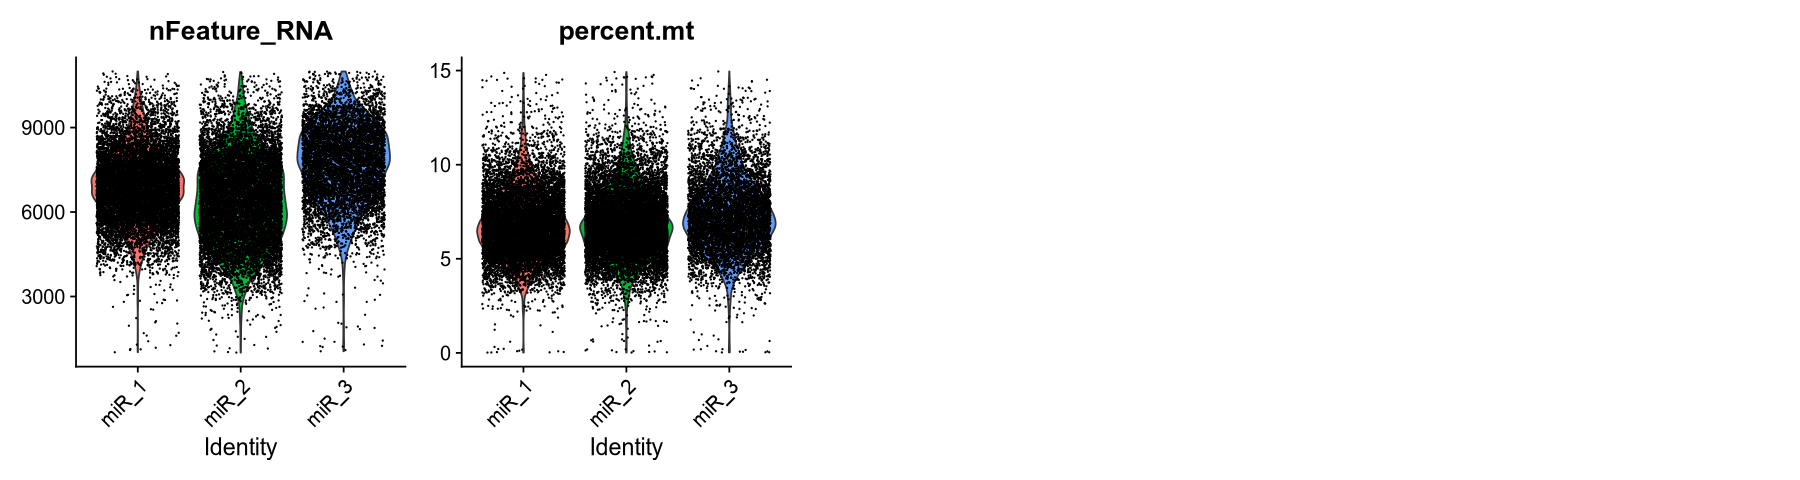

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 4)
feats <- c("nFeature_RNA", "percent.mt")
VlnPlot(adata.miR, group.by = "sample", features = feats, pt.size = 0.01, ncol = 5)

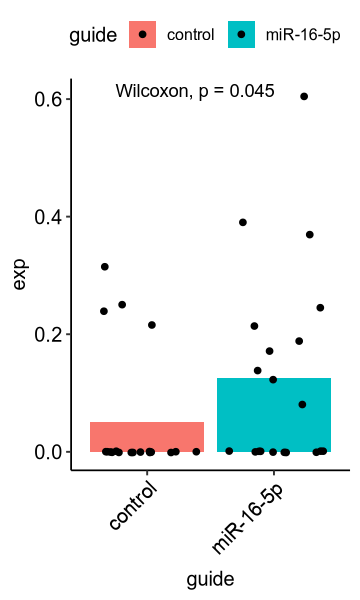

In [ ]:
options(repr.plot.width = 3, repr.plot.height = 5)
set.seed(1)
mtx = adata.miR@assays$RNA@data
mir16 = sample(mtx['VEGFA', which(meta$guide == 'hsa-miR-16-5p')], size = length(which(meta$guide == 'hsa-miR-16-5p')))

sampling_indexes = sample(x = which(startsWith(meta$guide, 'TuD_NC')), size = length(which(meta$guide == 'hsa-miR-16-5p')), replace = FALSE)
control = mtx['VEGFA', sampling_indexes]

df = data.frame(guide = c(rep('control', length(control)), rep('miR-16-5p', length(mir16))), exp = c(control, mir16)) 
rownames(df) = NULL
saveRDS(df, '/home/ssobti/projects/mir_tud/fig_output/data/fig1/VEGFA_miR16_control_single_cell.rds')

df %>%
  ggplot(aes(x = guide, y = exp, fill = guide)) + geom_bar(position = "dodge", stat = "summary", fun = "mean") + stat_compare_means(method = 'wilcox.test', method.args = list(alternative = "greater")) + geom_jitter() +
  theme_pubr() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [ ]:
## Fig 1b stats
print(paste('Total cells:', dim(meta)[1]))
print(paste('Total perturbations:', length(unique(meta$miR.family))))
print(paste('Number of miR families perturbed:', sum(stringr::str_count(unique(meta$miR.family), "/") > 0)))
print(paste('Number of unique miR perturbed:', length(unique(meta$miR.family)) - 1 - sum(stringr::str_count(unique(meta$miR.family), "/") > 0)))
print(paste('Number of cells per perturbation (median):', median(table(meta$miR.family))))
print(paste('Number of genes per cell (median):', median(meta$nFeature_RNA)))

[1] "Total cells: 29348"
[1] "Total perturbations 336"
[1] "Number of miR families perturbed: 58"


[1] "Number of unique miR perturbed: 277"
[1] "Number of cells per perturbation (median): 74"
[1] "Number of genes per cell (median): 6919"


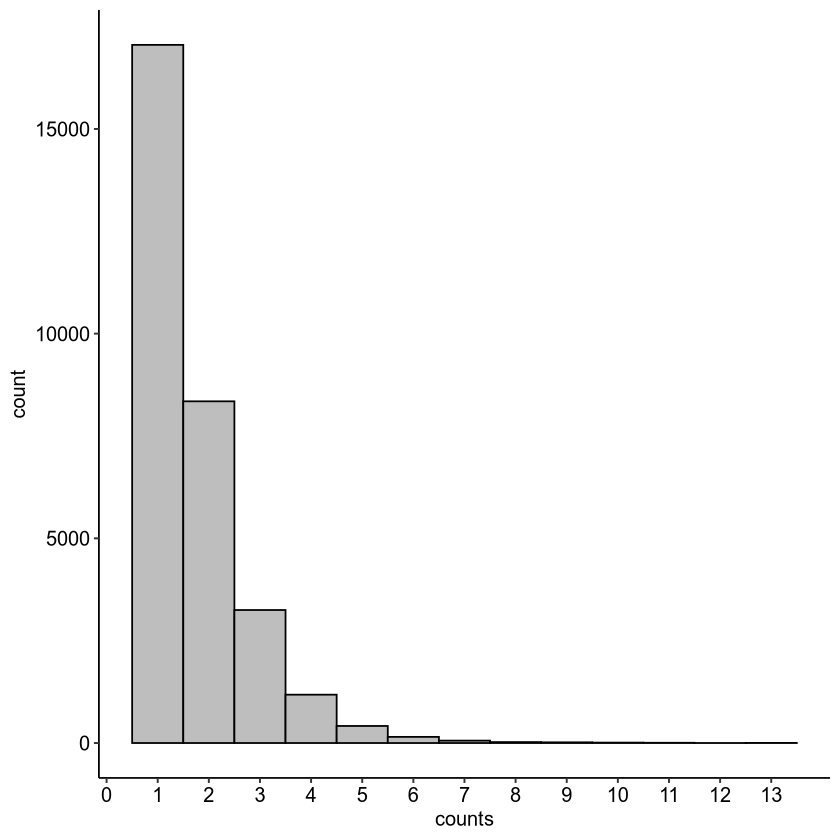

In [3]:
geomux_inputs_miR = read.csv('/home/ssobti/projects/mir_tud/uploaded_data/geomux_input_and_output_larisa/inputs/miR.concat.tsv', sep = '\t', header = F)
colnames(geomux_inputs_miR) = c('barcode', 'guide', 'n_umi')
guides_per_cell_miR = geomux_inputs_miR %>% select(barcode, guide) %>% group_by(barcode) %>% summarize(counts = n())
saveRDS(guides_per_cell_miR, '/home/ssobti/projects/mir_tud/fig_output/data/fig1/guides_per_cell_miR.rds')
ggplot(guides_per_cell_miR, aes(x = counts)) + geom_histogram(binwidth = 1, color="black", fill="grey") + theme_pubr() + scale_x_continuous(breaks = seq(0, max(guides_per_cell_miR$counts), by = 1))

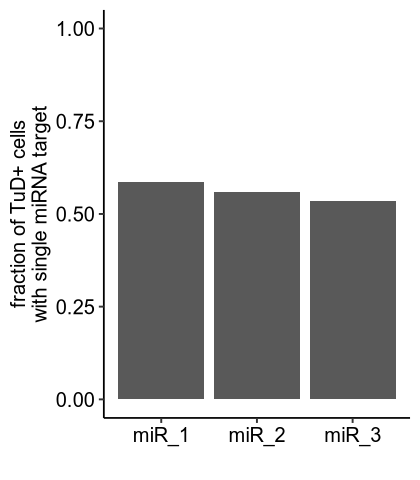

In [53]:
options(repr.plot.width = 3.5, repr.plot.height = 4)
cells_assiged_single_guide = as.data.frame(table(meta$sample)) %>% `colnames<-` (c('well', 'cells_single_guide'))
total_cells = as.data.frame(table(sapply(stringr::str_split(string = geomux_inputs_miR$barcode, pattern = ":"), '[[', 1))) %>% `colnames<-` (c('well', 'total_cells'))
ratio_df = merge(cells_assiged_single_guide, total_cells, by = 'well')
ratio_df$ratio = ratio_df$cells_single_guide / ratio_df$total_cells
saveRDS(ratio_df, '/home/ssobti/projects/mir_tud/fig_output/data/fig1/miR_tud_positive_ratio_df.rds')
ratio_df %>% ggplot(aes(x = well, y = ratio)) + geom_bar(stat="identity") + theme_pubr() + ylim(c(0, 1)) + xlab('') + ylab('fraction of TuD+ cells\nwith single miRNA target')

In [3]:
meta = adata.miR@meta.data
guide_to_family_key = meta[,c('guide', 'miR.family')] %>% distinct()
guide_to_family_key = guide_to_family_key[!startsWith(guide_to_family_key$guide, 'TuD_NC'),]
write.csv(guide_to_family_key, '/home/ssobti/projects/mir_tud/notebooks/miR_basic_analysis/miR_family_key.csv', row.names = F)
guide_to_family_key$family_status = ifelse(grepl('/', guide_to_family_key$miR.family), 'Family', 'Unique')

families = guide_to_family_key %>% filter(family_status == 'Family') %>% pull(miR.family) %>% unique()
families_miR_dictionary_list = lapply(families, function(x) {guide_to_family_key$guide[guide_to_family_key$miR.family == x]})
names(families_miR_dictionary_list) = families
families_miR_dictionary_list = families_miR_dictionary_list[lapply(families_miR_dictionary_list, function(x) {length(x)}) > 1]
filtered_families = names(families_miR_dictionary_list)
guide_to_family_key$family_status = ifelse(guide_to_family_key$miR.family %in% filtered_families, 'Family', 'Unique')

meta$family_status = guide_to_family_key[match(meta$miR.family, guide_to_family_key$miR.family), 'family_status']
meta$family_status[is.na(meta$family_status)] = 'Non-targeting control'
meta$miR.family[meta$miR.family == 'NA'] = meta$guide[meta$miR.family == 'NA']

miR_df = meta %>% group_by(family_status) %>% count(miR.family) %>% `colnames<-`(c('family_status', 'guide', 'count'))
miR_df$family_status = factor(miR_df$family_status, levels = c('Non-targeting control', 'Unique', 'Family'))
# saveRDS(miR_df, '/home/ssobti/projects/mir_tud/fig_output/data/fig1/miR_qc_cell_guide_counts.rds')

In [4]:
saveRDS(families_miR_dictionary_list, '/home/ssobti/projects/mir_tud/fig_output/data/fig1/miR_qc_families_miR_dictionary_list.rds')

In [6]:
length(families_miR_dictionary_list)

[1] 19

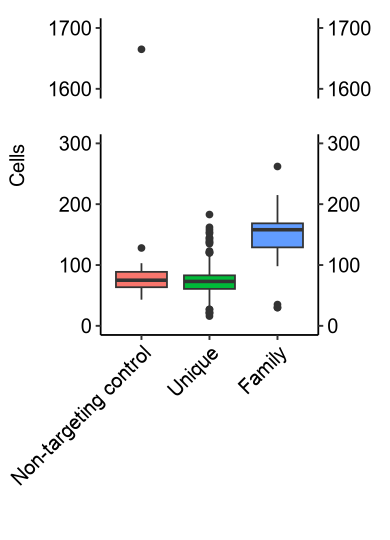

In [35]:
options(repr.plot.width = 3.25, repr.plot.height = 4.5)
miR_df %>% ggplot(aes(x = family_status, y = count, fill = family_status)) + xlab('') + geom_boxplot(show.legend = FALSE) + 
theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), axis.title.y = element_text(hjust = 0.7)) + scale_y_break(c(300, 1590), ticklabels = c(300, 1600, 1700), space = 0.65) + ylim(c(0, 1710)) +
scale_fill_discrete() + ylab('Cells')

In [ ]:
miR_family_df = data.frame(table(guide_to_family_key$family_status)) %>% `colnames<-`(c('family_status', 'count'))
miR_family_df$family_status = as.character(miR_family_df$family_status)
miR_family_df = rbind(miR_family_df, c('Non-targeting Control', 20))
miR_family_df$count = as.numeric(miR_family_df$count)
miR_family_df$percent = (miR_family_df$count / sum(miR_family_df$count)) * 100
miR_family_df$family_status = c('Family', 'Unique', 'Non-targeting Control')
miR_family_df$family_status = factor(miR_family_df$family_status, levels = c('Non-targeting Control', 'Unique', 'Family'))
# saveRDS(miR_family_df, '/home/ssobti/projects/mir_tud/fig_output/data/fig1/miR_qc_family_counts.rds')

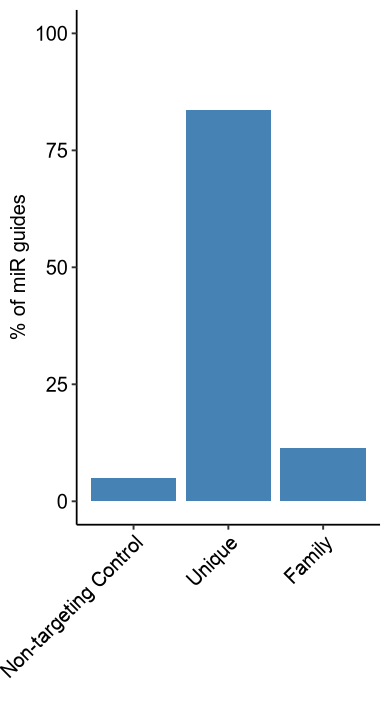

In [37]:
options(repr.plot.width = 3.25, repr.plot.height = 6)
miR_family_df %>% ggplot(aes(x = family_status, y = percent)) +
  geom_bar(stat = "identity", fill = "steelblue") + theme_pubr() + ylab('% of miR guides') + xlab('') + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + ylim(c(0, 100))